In [323]:
!pip install transformers
!pip install shap
!pip install scikit-plot

     |████████████████████████████████| 358kB 3.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491625 sha256=244865910f4a7f18e02555328db4a6e447a3b674a7ccbb6ec4808cfc1a5ee1c3
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


# Dataset & training

In [226]:
## prepare datasets

In [227]:
import pandas as pd
import numpy as np

In [228]:
df = pd.read_csv('dataset.csv', usecols = ['text', 'text_clean', 'is_troll'])

In [229]:
df = df[df['is_troll'].notna()]
df = df[df['text_clean'].notna()]

In [230]:
df.is_troll.value_counts()

False    22457
True     17337
Name: is_troll, dtype: int64

In [231]:
count_class_0, count_class_1 = df.is_troll.value_counts()
df_class_0 = df[df['is_troll'] == False]
df_class_1 = df[df['is_troll'] == True]
df_class_0_under = df_class_0.sample(count_class_1)
df = pd.concat([df_class_0_under, df_class_1], axis=0)

In [232]:

df.is_troll.value_counts()

True     17337
False    17337
Name: is_troll, dtype: int64

In [233]:
df.head()

,text,text_clean,is_troll
5040,RT @IISuperwomanII: Dancing with my little sis...,: Dancing with my little in to my song . 🇰🇪🔥 …,False
2576,RT @TaeyongsPrince: Never forget this funny af...,: Never forget this funny moment,False
4671,RT @RahulPabra: #ज्ञान_का_अखाड़ा tomorrow rogu...,: ् ा ा ा ़ा tomorrow rogue gang of spirituali...,False
19299,RT @KunalChoudhary_: Modi is the only leader i...,: is the only leader in the world who that sen...,False
1477,RT @ncoxdzn: crush: 'hello anong name mo?'\n\n...,: crush : ' hello name mo ?' me :,False


In [234]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34674 entries, 5040 to 40083
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        34674 non-null  object
 1   text_clean  34674 non-null  object
 2   is_troll    34674 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [235]:
df['is_troll']= df['is_troll'].astype(float)

In [432]:
df

,text,text_clean,is_troll
5040,RT @IISuperwomanII: Dancing with my little sis...,: Dancing with my little in to my song . 🇰🇪🔥 …,0.0
2576,RT @TaeyongsPrince: Never forget this funny af...,: Never forget this funny moment,0.0
4671,RT @RahulPabra: #ज्ञान_का_अखाड़ा tomorrow rogu...,: ् ा ा ा ़ा tomorrow rogue gang of spirituali...,0.0
19299,RT @KunalChoudhary_: Modi is the only leader i...,: is the only leader in the world who that sen...,0.0
1477,RT @ncoxdzn: crush: 'hello anong name mo?'\n\n...,: crush : ' hello name mo ?' me :,0.0
...,...,...,...
40079,"RT @gerfingerpoken: Obama Eats Salmon, Ignore...",": Eats Salmon , Navy Provocation in Thinker -",1.0
40080,RT @330Kingish: #BlackLivesMatter:Sandy Booker...,: : Sandy Booker cried after ' s election in 2...,1.0
40081,RT @docmurdock: EXACTLY!! Carry the message fa...,: EXACTLY !! Carry the message far and wide an...,1.0
40082,RT @ChristieC733: Obama's 3.0: \nMore Weak Lea...,": ' s 3 . 0 : More Weak Leadership , more , mo...",1.0


In [236]:
texts, labels = df['text_clean'].values, df['is_troll'].values

In [237]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [238]:
train_texts.shape, train_labels.shape

((22191,), (22191,))

In [239]:
sum(train_labels) / len(train_labels)

0.5003379748546708

In [240]:
## trian model

In [241]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [242]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True) #length of the represetntaion?
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

In [446]:
len(train_encodings[2])

68

In [244]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels,
)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)


In [351]:

from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])

history = model.fit(train_dataset.shuffle(1000),
                    epochs=3, 
                    batch_size=16,
                    validation_data=val_dataset)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [167]:
model.evaluate(test_dataset)

434/434 [==============================] - 16s 33ms/step - loss: 0.7862 - accuracy: 0.7810


[0.7861822247505188, 0.7809661030769348]

# Evaluation

In [260]:
from sklearn import metrics

def evaluate(model, test_dataset, test_labels):
  pred_output = model.predict(test_dataset)
  y_pred_prob = tf.nn.softmax(pred_output.logits,axis=-1).numpy()
  threshold = 0.5
  y_true = test_labels
  y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)
  return {
            'accuracy_score': metrics.accuracy_score(y_true, y_pred_bool),
            'precision_score': metrics.precision_score(y_true, y_pred_bool),
            'recall_score': metrics.recall_score(y_true, y_pred_bool),
        }

In [261]:
evaluate(model, test_dataset, test_labels)

{'accuracy_score': 0.7837058399423216,
 'precision_score': 0.8110863332271424,
 'recall_score': 0.7373298580944107}

In [263]:
pred_output = model.predict(test_dataset)
y_pred_prob = tf.nn.softmax(pred_output.logits,axis=-1).numpy()
threshold = 0.5
y_true = test_labels
y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)

### evaluation visualisation

In [284]:
import pathlib
import pandas as pd
import numpy as np
import datetime
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import scikitplot as skplt


class EvaluationReport:
    def __init__(self, y_true, y_pred_prob, threshold: float):
        """
        Provides evaluation metrics & plotting for churn prediction purposes.
        Args:
            y_true: array-like, array of true labels
            y_pred_prob: array-like, predicted probability, with one column per class - just like output of scikit_model.predict_proba,
                0th column should be churn == False probability, 1th column churn == True probability
            threshold: threshold for binary classification label
        """
        self.y_true = y_true
        self.y_pred_prob = y_pred_prob
        self.y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)
        self.threshold = threshold
        self.predictions_explanations = pd.DataFrame()
    def plot_confusion_matrix(self):
        """
        Plots pretty confusion matrix.
        """
        assert self.y_true.values.dtype == 'bool' and self.y_pred_bool.dtype == 'bool'
        cm = confusion_matrix(self.y_true.values, self.y_pred_bool)
        tn, fp, fn, tp = cm.ravel()
        matrix_to_plot = [[tp, fp], [fn, tn]]

        group_names = ['TN', 'FP', 'FN', 'TP']
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = [
            '{0:.2%} of all'.format(value) for value in cm.flatten() / np.sum(cm)
        ]
        row_percentages = [
            '{0:.2%} of negatives'.format(tn / (tn + fn)),
            '{0:.2%} of positives'.format(fp / (tp + fp)),
            '{0:.2%} of negatives'.format(fn / (fn + tn)),
            '{0:.2%} of positives'.format(tp / (tp + fp)),
        ]
        labels = [
            f'{v1}\n{v2}\n{v3}\n{v4}'
            for v1, v2, v3, v4 in zip(
                group_names, group_counts, group_percentages, row_percentages
            )
        ]
        tn, fp, fn, tp = labels
        labels = [[tp, fp], [fn, tn]]
        labels = np.asarray(labels).reshape(2, 2)

        ax = plt.subplot()
        sns.heatmap(
            matrix_to_plot,
            annot=labels,
            cmap="YlGnBu",
            linewidths=0.5,
            fmt='',
            ax=ax,
            cbar=False,
            xticklabels=[True, False],
            yticklabels=[True, False],
            annot_kws={"size": 16},
            square=True,
        )

        sns.set(font_scale=1.4)
        ax.set_xlabel('True values')
        ax.set_ylabel('Predicted values')
        plt.rc("figure", figsize=(10, 10))

    def plot_roc_curve(self):
        """
        Plots ROC curve.
        """
        plt.rc("figure", figsize=(7, 7))
        skplt.metrics.plot_roc(
            self.y_true,
            self.y_pred_prob,
            plot_micro=False,
            plot_macro=False,
            classes_to_plot=True,
            cmap="plasma",
        )
        plt.show()

### confusition matrix ans RoC

In [285]:

r = EvaluationReport(pd.DataFrame(y_true.astype(bool)), y_pred_prob, 0.5)

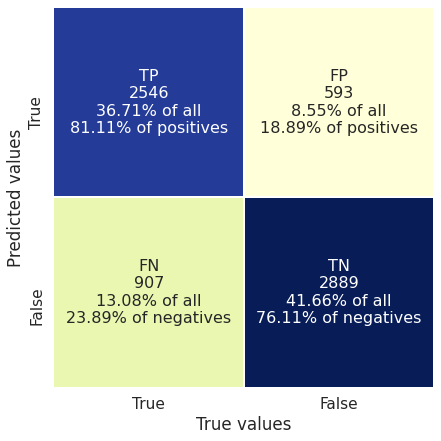

In [286]:
r.plot_confusion_matrix()

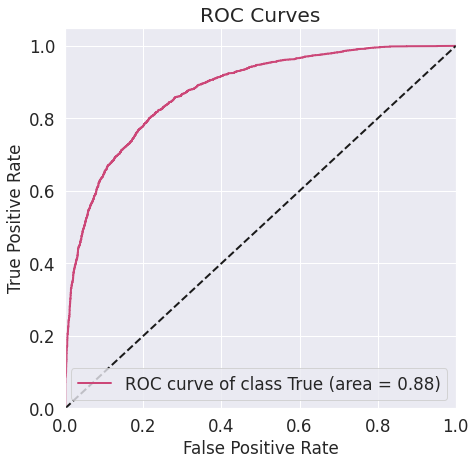

In [287]:
r.plot_roc_curve()

# example prediction & shapley values

In [514]:
from transformers import pipeline

russian_trolls_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer, return_all_scores=True) #tockeniser parms?

In [520]:
sample_text = 'BREAKING 🚨 HUGE in streets of ! like real chaos !'
russian_trolls_pipeline(sample_text,truncation=True)

[[{'label': 'LABEL_0', 'score': 0.013860689476132393},
  {'label': 'LABEL_1', 'score': 0.9861393570899963}]]

In [521]:
sample_text = 'I hate hilary and trump'
russian_trolls_pipeline(sample_text, truncation=True)

[[{'label': 'LABEL_0', 'score': 0.007896915078163147},
  {'label': 'LABEL_1', 'score': 0.9921030402183533}]]

In [522]:
sample_text = 'I love pizza, need to talk with God!'
russian_trolls_pipeline(sample_text, truncation=True)

[[{'label': 'LABEL_0', 'score': 0.5416922569274902},
  {'label': 'LABEL_1', 'score': 0.458307683467865}]]

In [523]:
#the above can be deployed

In [564]:
short_data = df.sample(4).text_clean.values

In [565]:
# define the explainer
explainer = shap.Explainer(russian_trolls_pipeline,  russian_trolls_pipeline.tokenizer)

In [568]:
short_data

array(['foot fetish pussy licking petite close up pussy pussy massage',
       ': Trump Then INSANE Drunken Tweet Against China ; Here It Is China Trump',
       ": Gorgeous 1941 capture life on the streets of ' s South Side",
       'Ask not what your country can do for you . But ask what you can do for your country'],
      dtype=object)

In [566]:
shap_values = explainer(short_data)


Partition explainer: 5it [00:11,  2.34s/it]               


In [567]:
shap.plots.text(shap_values[:,:,"LABEL_1"])


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
